In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import control as ct
from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.manifold import Isomap
from spynal.spikes import density
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

sys.path.append('/om2/user/eisenaj/code/repos/jPCA')
from jPCA import jPCA

plt.style.use('../../sci_style.py')

# Functions

In [5]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
def get_bins(spike_mat, bin_size):
    """
    Helper function for get_up_down_raw() function. 

    Calculate number of bins based on bin_size, remove extra
    data at end, and return spikes/bin count array.
    """
    trial_length = spike_mat.shape[1]
    n_bins = np.floor(trial_length / bin_size)

    cut_ind = int(n_bins*bin_size)

    clipped_spike_mat = spike_mat[:,:cut_ind]
    
    return sum_bins(clipped_spike_mat, n_bins)
    
def sum_bins(spike_mat, n_bins):
    """
    Helper function for get_bins() function. 

    Break apart spike_mat (0/1 spike array) into n_bins and
    return (n_bin,) length array containing spike counts per bin.
    """
    split = np.hsplit(spike_mat, n_bins)
    join = np.stack(split)
    
    return join.sum(axis=(1,2))

def get_up_down_raw(area_spike_dict, bin_size=200, Fs=1000, thresh=0.1, 
                trange=None, smooth=True):
    """
    For each spike array in area_spike_dict, get 0/1 Up/Down array at bin_size 
    resolution.
    Optional smooth: fill in 101 case with 111
    Returns dictionary with Up/Down raw array per region.
    """
    
    areas = list(area_spike_dict.keys())

    data_length = area_spike_dict[areas[0]].shape[1]
    # n_bins = int(np.floor(data_length / bin_size))
    
    if trange is None:
        trange = np.arange(data_length)
    
    binned_up_down_dict = {}
    
    for a, spikes in area_spike_dict.items():
        if a == '7b':
            thresh = 0.2
        else:
            thresh = thresh

        binned = get_bins(spikes, bin_size)
        binned_up_down_dict[a] = (((binned / area_spike_dict[a].shape[0])\
                        * (200/bin_size)) > thresh).astype(float)

    if smooth:
        for a, binned in binned_up_down_dict.items():
            for n in range(binned.size):
                if n == 0 or n == binned.size-1:
                    pass
                else:
                    if binned[n-1] == 1 and binned[n+1] == 1:
                        binned[n] = 1

    up_down_dict = {k: np.repeat(v, bin_size) for k,v\
                    in binned_up_down_dict.items()}
    
    return up_down_dict

# NOTE - some shoddy conditionals for handling boundary issues
# WATCH FOR ISSUES
def get_up_edges(up_down_array):
    """
    Get indices for starts/ends of sequence of ones in up_down_array.
    Check / fix common errors due to boundary issues.
    """
    starts = np.where(np.diff(up_down_array) == 1)[0] + 1
    ends = np.where(np.diff(up_down_array) == -1)[0] + 1
    
    if ends[0] <= starts[0]:
        ends = ends[1:]
        starts = starts[:-1]
        
    if ends.size != starts.size:
        min_size = min(ends.size, starts.size)
        starts = starts[:min_size]
        ends = ends[:min_size]
    
    return starts, ends



def trim_up_down_array(expanded_up, area_spike_seg):
    """
    Remove trailing Up/Down labels based on 0-spike counts at 
    beginning/end of Up segement in Up/Down array.
    """
    trimmed_up = np.zeros(expanded_up.size)
    up_starts, up_ends = get_up_edges(expanded_up)
    # need to handle case where these aren't equal?
    for i in range(up_starts.size):
        s = up_starts[i]
        e = up_ends[i]
        up_seg = area_spike_seg[:,s:e]
        
        nonzeros = np.nonzero(up_seg.sum(0))[0]
        new_s = s + nonzeros[0]
        new_e = s + nonzeros[-1]
        
        trimmed_up[new_s:new_e] = 1
        
    return trimmed_up

def trim_up_down(expand_dict, area_spikes_dict):
    """
    Apply trim_up_down_array to each region in dictionary.
    """
    trimmed_dict = {}
    for a in expand_dict.keys():
        expand_up = expand_dict[a]
        spikes_seg = area_spikes_dict[a]
        
        trimmed_dict[a] = trim_up_down_array(expand_up, spikes_seg)
        
    return trimmed_dict

def get_up_down(area_spike_dict, bin_size=200):
    """
    Apply full Up/Down processing to each region in area_spike_dict.
    Returns new dictionary w/ full/processed Up/Down array per region.
    """
    raw_up_down_dict = get_up_down_raw(area_spike_dict, bin_size=bin_size)
    up_down_dict = trim_up_down(raw_up_down_dict, area_spike_dict)

    return up_down_dict

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Run All

In [4]:
session_list = os.listdir('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results')

In [5]:
session_list = session_list[:2]

In [6]:
device = 'cuda'

In [7]:
save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/contraction"

In [8]:
for session in session_list:
    if not os.path.exists(os.path.join(save_dir, session)):

        # =============================
        # LOAD METADATA
        # =============================
        print("loading data...")
        all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
        data_class = get_data_class(session, all_data_dir)

        os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
        # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
        # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
        # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

        variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
        session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
        electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

        eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
        eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

        section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
        )
        sections = list(section_times.keys())

        tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
        tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

        print("data loaded!")
        print("loading directory")

        chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
        if len(chunked_folder) == 0:
            print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
        else:
            chunked_folder = chunked_folder[0]

        directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

        print("directory loaded!")

        norm_folder="NOT_NORMED"
        # -----------------------------------------
        # LOAD GRID RESULTS
        # -----------------------------------------

        print("Loading grid search results...")

        session_results = {}
        session_results[session] = {}
        # data_processing_df_grid = deepcopy(mp_args.data_processing_df)

        grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
        areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

        for area in areas:
            df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
            for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
                t = float(f.split('_')[0])
                file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
                df_new = pd.DataFrame(pd.read_pickle(file_path))
                if np.isnan(df_new.AIC).sum() > 0:
                    print(file_path)
                df_new = df_new.set_index(['window', 'matrix_size', 'r'])
                for i, row in df_new.iterrows():
                    if i in df.index:
                        df.loc[i, 'AICs'].append(row.AIC)
                        df.loc[i, 'time_vals'].append(t)
                        df.loc[i, 'file_paths'].append(file_path)
                    else:
                        df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

            df = df.loc[df.index.sortlevel()[0]]
            session_results[session][area] = df

        print("Grid search results loaded!")

        # ================
        # INDIVIDUAL AREAS
        # ================ 
        window_ind, matrix_size_ind, r_ind, all_results = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

        # ================
        # ALL AREAS
        # ================ 
        if 'all' in session_results[session].keys():
            window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})

        # =============================
        # PROCESS DATA
        # =============================

        print("processing data...")
        num_windows = int(len(lfp_schema['index'][0])/window_ind)
        contraction_rates = {}

        iterator = tqdm(total=len(areas)*num_windows)

        for area in areas:
            contraction_rates[area] = []

            if area == 'all':
                unit_indices = np.arange(len(electrode_info['area']))
            else:
                unit_indices = np.where(electrode_info['area'] == area)[0]

            if area == 'all':
                window, matrix_size, r = window_all, matrix_size_all, r_all
            else:
                window, matrix_size, r = window_ind, matrix_size_ind, r_ind

            for i in range(num_windows):
                t = i*window
                window_start = t*dt
                window_end = (t + window)*dt

                signal = load_window_from_chunks(window_start, window_end, directory, dimension_inds=unit_indices)
                delase = DeLASE(signal[:window], matrix_size=matrix_size, use_torch=True, device=device)
                delase.compute_havok_dmd(r=r)
                n = delase.n*delase.p
                I = torch.eye(n).to(device)
                A = ((delase.A - I)/dt)
                M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                eigvals_M = torch.real(torch.linalg.eigvals(M))
                contraction_rate = (1/eigvals_M.max()).cpu().numpy()

                row = dict(
                    session=session,
                    area=area,
                    start_time=window_start,
                    end_time=window_end,
                    contraction_rate=contraction_rate
                )

                contraction_rates[area].append(row)

                iterator.update()
            contraction_rates[area] = pd.DataFrame(contraction_rates[area])
        iterator.close()

        pd.to_pickle(contraction_rates, os.path.join(save_dir, session))

In [9]:
leadup = 15
post = 25

In [109]:
all_rets = {}
session_infos = {}
eyes_closes = {}
eyes_opens = {}
for session in tqdm(session_list):
    # =============================
    # LOAD METADATA
    # =============================
#     print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

    session_infos[session] = session_info
    
    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']
    
    eyes_opens[session] = eyes_open
    eyes_closes[session] = eyes_close
    
    section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
    tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
    
    contraction_rates = pd.read_pickle(os.path.join(save_dir, session))
    
    all_rets[session] = {}
    for area in contraction_rates.keys():
        all_rets[session][area] = contraction_rates[area][np.logical_and(contraction_rates[area].start_time >= session_info['drugStart'][0] - leadup*60, contraction_rates[area].start_time <= session_info['drugEnd'][1] + post*60)]

  0%|          | 0/2 [00:00<?, ?it/s]

In [110]:
session_list

['Mary-Anesthesia-20160908-02', 'MrJones-Anesthesia-20160301-01']

In [111]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b': 'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}
# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

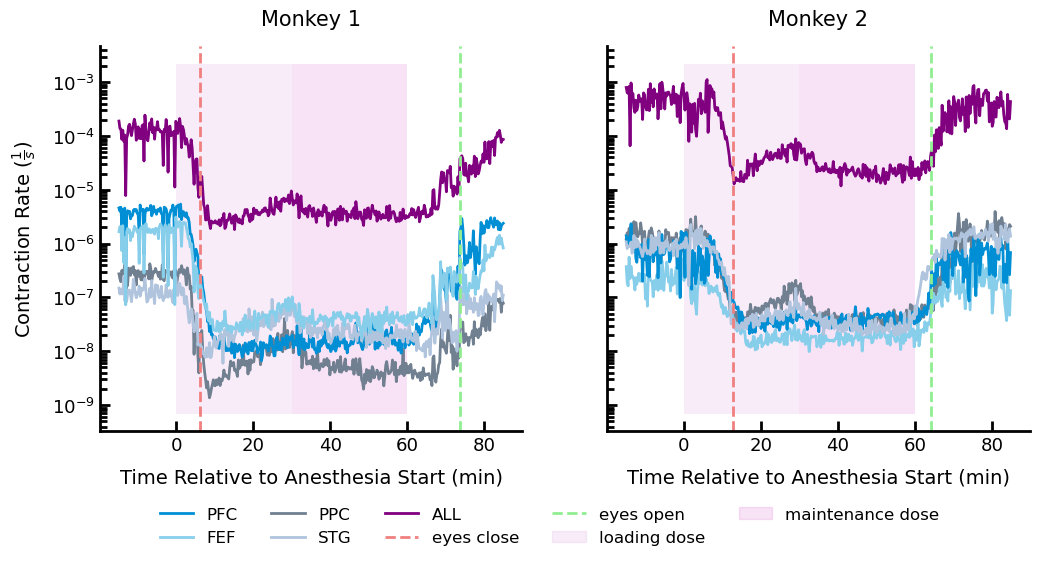

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
xlabel_fontsize = 14
ylabel_fontsize = 14
tick_fontsize = 13
legend_fontsize = 12
onplot_fontsize = 11
title_fontsize = 15

for i, session in enumerate(session_list):
    ax = axs[i]
    for area in all_rets[session].keys():
        ax.plot((all_rets[session][area].start_time - session_infos[session]['drugStart'][0])/60, all_rets[session][area].contraction_rate, color=area_colors[area])

    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax.set_xlabel('Time Relative to Anesthesia Start (min)', fontsize=xlabel_fontsize)
    if i == 0:
        ax.set_ylabel(r'Contraction Rate ($\frac{1}{s}$)', fontsize=ylabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
    ax.set_yscale('log')
    
    ax.axvline((eyes_closes[session] - session_infos[session]['drugStart'][0])/60, c='lightcoral', linestyle='--')
    ax.axvline((eyes_opens[session] - session_infos[session]['drugStart'][0])/60, c='lightgreen', linestyle='--')

    
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, edgecolor='none')
#     if i == 1:
#         step = 0.8
#     else:
#         step = 0
#     ax.text(20, ylim[0] + step, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
#     ax.text(45, ylim[0] + step, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)

        
for area in ['vlPFC', 'FEF', '7b', 'CPB', 'all']:
    ax.plot([], [], color=area_colors[area], label=area_labels[area]) 
ax.plot([], [], c='lightcoral', linestyle='--', label='eyes close')
ax.plot([], [], c='lightgreen', linestyle='--', label='eyes open')
ax.fill_between([], [], [], color='plum', alpha=0.2, label='loading dose')
ax.fill_between([], [], [], color='orchid', alpha=0.2, label='maintenance dose')
    
        
fig.legend(bbox_to_anchor=(0.5, -0.08), ncol=5, loc='center', fontsize=legend_fontsize)
plt.show()

In [161]:
scipy.stats.ttest_ind(wake_rows, anesthesia_rows, alternative='greater')

Ttest_indResult(statistic=25.487867920246675, pvalue=1.3393890940298498e-61)

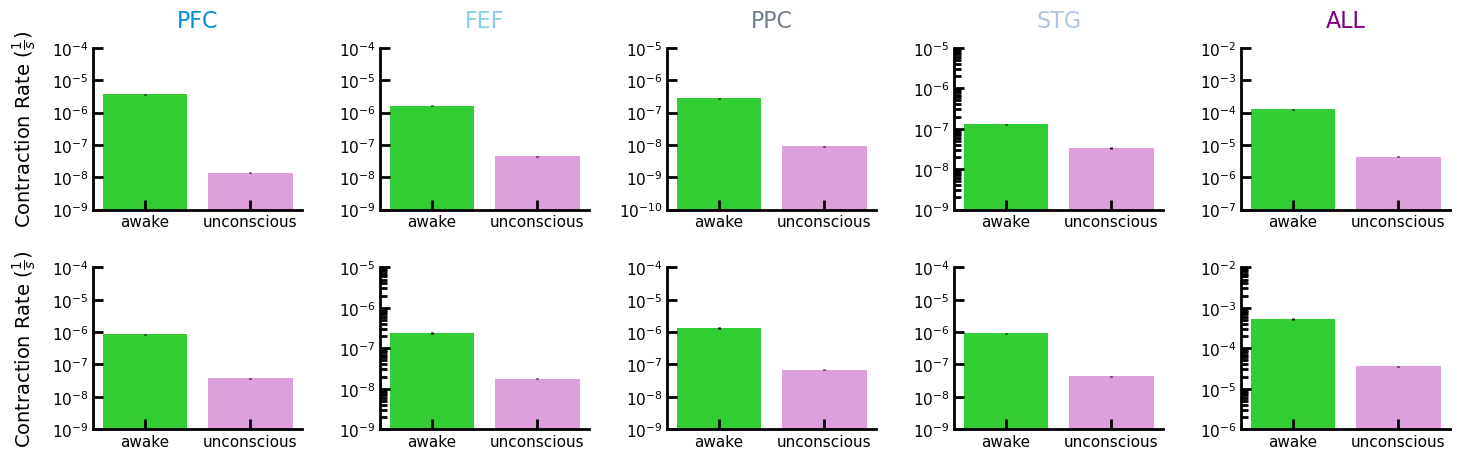

In [114]:
tick_fontsize=11
title_fontsize = 16
ylabel_fontsize=14
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
for i, session in enumerate(session_list):
#     for j, area in enumerate(areas):
    for j, area in enumerate(['vlPFC', 'FEF', '7b', 'CPB', 'all']):
        ax = axs[i, j]
        wake_rows = all_rets[session][area][all_rets[session][area].start_time <= session_infos[session]['drugStart'][0]].contraction_rate
        anesthesia_rows = all_rets[session][area][np.logical_and(all_rets[session][area].start_time >= session_infos[session]['drugStart'][0] + 15*60, all_rets[session][area].start_time <= session_infos[session]['drugEnd'][1] - 15*60)].contraction_rate
        
        
        se_wake = np.std(wake_rows)/np.sqrt(len(wake_rows))
        se_anesthesia = np.std(anesthesia_rows)/np.sqrt(len(anesthesia_rows))
        
#         ax.bar('awake', np.log10(wake_rows.mean()), yerr=np.log10(se_wake), color='limegreen')
#         ax.bar('unconscious', np.log10(anesthesia_rows.mean()), yerr=np.log10(se_anesthesia), color='plum')
        ax.bar('awake', wake_rows.mean(), yerr=se_wake, color='limegreen')
        ax.bar('unconscious', anesthesia_rows.mean(), yerr=se_anesthesia, color='plum')
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks())
        ax.tick_params(labelsize=tick_fontsize)
        if i == 0:
            ax.set_title(area_labels[area], color=area_colors[area], fontsize=title_fontsize)
        if j == 0:
            ax.set_ylabel(r'Contraction Rate ($\frac{1}{s}$)', fontsize=ylabel_fontsize)
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
plt.tight_layout()
plt.show()

# Linear Systems

In [42]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1, random_seed=42, return_A=False):

    np.random.seed(random_seed)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    if return_A:
        if awake == 1:
            return x, A_awake
        else:
            return x, A_anesthesia
    else:
        return x

In [43]:
use_torch=True
device = 'cuda'

In [44]:
NUM_RUNS = 1

In [45]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
    r_vals=np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000])
)


prediction_time = 5000
transient = 2000

for i in range(NUM_RUNS):
    if not os.path.exists(os.path.join(save_dir, f"RUN_{i}")):
        print("="*40)
        print(f"RUN {i}")
        print("="*40)

        print("Simulating...")
        trajs = {}
        As = {}
        for lam in lams:
            x_1, A = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1, random_seed=42 + i, return_A=True)
            trajs[lam] = x_1
            As[lam] = A
        #         plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
        #     plt.legend()
        #     plt.show()
        num_samples = 10
        indices = np.random.choice(np.arange(n), num_samples, replace=False)
        for key in trajs.keys():
            trajs[key] = trajs[key][:, indices]
        print("Simulated!")

        signals = trajs

        mean_stab_curve = True
        true_vals = lams
        keys = np.array(lams)
        key_inds = np.arange(len(lams))

        print("Computing DeLASE...")
        results = []
        iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
        for window in parameter_grid.window_vals:
            for matrix_size in parameter_grid.matrix_size_vals:
                delases = {}
                exp_variances = {}
        #         train_signals = []
                test_signals = {}
                for key, signal in signals.items():
                    train_signal = signal[transient:transient + window]
                    test_signal = signal[transient + window:transient + window + prediction_time]
                    delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                    delase.to('cpu')
                    if use_torch:
                        exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                    else:
                        exp_variances[key] = delase.cumulative_explained_variance
                    delases[key] = delase
        #             train_signals.append(train_signal)
                    test_signals[key] = test_signal
                for r in parameter_grid.r_vals:
                    if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                        stab_curves = {}
                        AICs = {}
                        for key, delase in delases.items():
                            delase.to('cuda')
                            delase.compute_havok_dmd(r=r)
                            delase.get_stability(max_freq=500, max_unstable_freq=125)

                            AICs[key] = compute_AIC(delase, test_signals[key])
                            if use_torch:
                                stab_curves[key] = delase.stability_params.cpu()
                            else:
                                stab_curves[key] = delase.stability_params

                        if use_torch:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                        else:
                            exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])

                        results.append(dict(
                            window=window,
                            matrix_size=matrix_size,
                            r=r,
                            exp_variances=exp_variances,
                            AICs=AICs,
                            stab_curves=stab_curves,
                        ))

                    iterator.update()
        iterator.close()

        results = pd.DataFrame(results)
        results_dict = {}
        for key in lams:
            ret_temp = results.copy()
            ret_temp = ret_temp.drop('AICs', axis=1)
            ret_temp = ret_temp.drop('stab_curves', axis=1)
            ret_temp = ret_temp.drop('exp_variances', axis=1)
            ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
            ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
            ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
            results_dict[key] = ret_temp

RUN 0
Simulating...
Simulated!
Computing DeLASE...


  0%|          | 0/216 [00:00<?, ?it/s]

In [46]:
## compute contraction rates

In [47]:
window, matrix_size, r, all_results = combine_grid_results(results_dict)

In [69]:
matrix_size

10

In [90]:
true_cr = np.zeros(len(lams))
pred_cr = np.zeros(len(lams))
for i, lam in tqdm(enumerate(lams), total=len(lams)):
    delase = DeLASE(signals[lam][:window], matrix_size=matrix_size, use_torch=True, device='cuda')
    delase.compute_havok_dmd(r=r)
    
    n = delase.n*delase.p
    I = torch.eye(n).to(device)
    A = ((delase.A - I)/dt)
    M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
    eigvals_M = torch.real(torch.linalg.eigvals(M))
    true_cr[i] = (1/eigvals_M.max()).cpu().numpy()
    
    n = 100
    I = np.eye(n)
    M = scipy.linalg.solve_continuous_lyapunov(As[lam].T, -I)
    eigvals_M = np.real(np.linalg.eigvals(M))
    pred_cr[i] = (1/eigvals_M.max())

  0%|          | 0/10 [00:00<?, ?it/s]

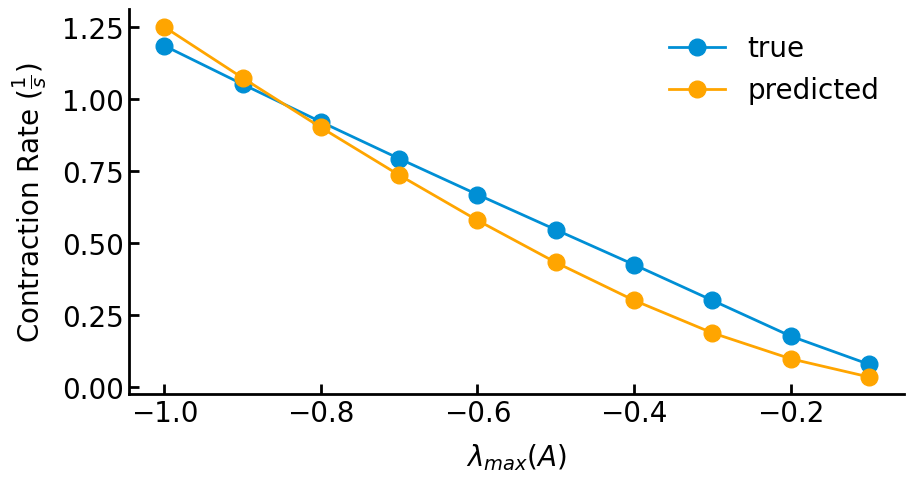

In [115]:
plt.plot(lams, true_cr, marker='o', markersize=12, label='true')
plt.plot(lams, pred_cr, c='orange', marker='o', markersize=12, label='predicted')
plt.xlabel(r'$\lambda_{max}(A)$')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y', which='both', left=True, right=False)
ax.set_ylabel(r'Contraction Rate ($\frac{1}{s}$)')
ax.legend()
plt.show()

# VDP

In [182]:
def vdp(x, t, mu):
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = mu*(1 - x[0]**2)*x[1] - x[0]
    return dx

In [250]:
t_span = [0, 200]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
mu = 0.8

In [251]:
sol = scipy.integrate.solve_ivp(lambda t, x: vdp(x, t, mu=mu), y0=np.random.randn(2), t_span=t_span, t_eval=t_eval)

In [252]:
signal = sol.y.T

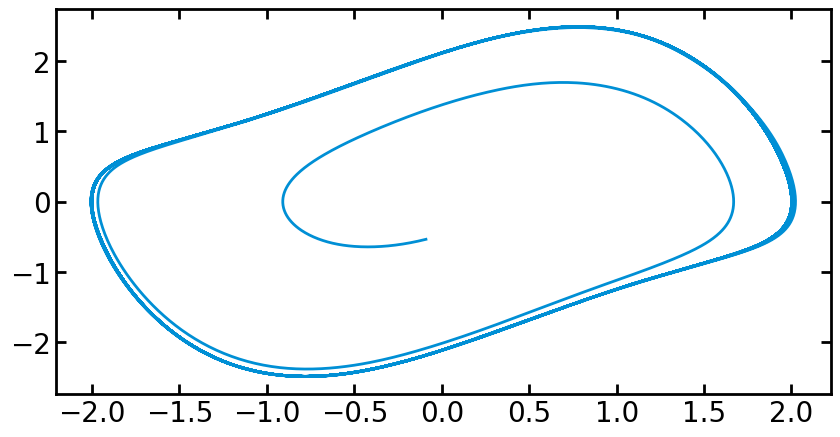

In [253]:
plt.plot(signal[:, 0], signal[:, 1])

In [254]:
signal.shape

(20000, 2)

In [255]:
delase = DeLASE(signal[:15000], p=1000, use_torch=True, device='cuda')

In [256]:
delase.compute_havok_dmd()

In [257]:
preds = delase.predict_havok_dmd(signal, tail_bite=True)

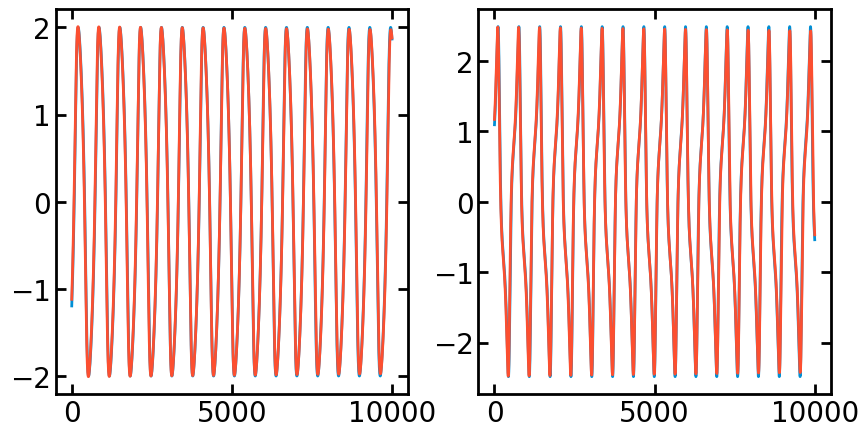

In [258]:
start = 10000
end = 20000
plt.subplot(1, 2, 1)
plt.plot(signal[start:end, 0])
plt.plot(preds[start:end, 0].cpu())

plt.subplot(1, 2, 2)
plt.plot(signal[start:end, 1])
plt.plot(preds[start:end, 1].cpu())
plt.show()

In [259]:
n = delase.n*delase.p
I = torch.eye(n).to(device)
A = ((delase.A - I)/dt)
M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
eigvals_M = torch.real(torch.linalg.eigvals(M))
contraction_rate = (1/eigvals_M.max()).cpu().numpy()

In [249]:
contraction_rate

array(3.12846123e-11)

In [226]:
contraction_rate

array(2.41744623e-11)

In [260]:
contraction_rate

array(9.44710487e-13)

In [228]:
evals = torch.linalg.eigvals(A)

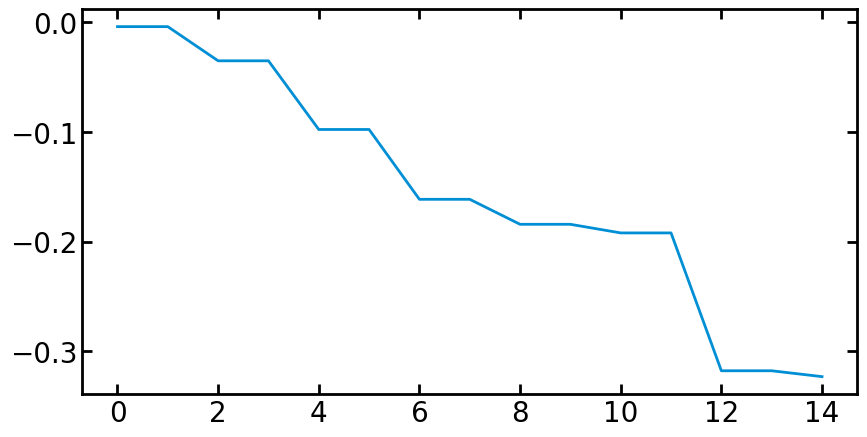

In [233]:
plt.plot(torch.real(evals[torch.flip(torch.argsort(torch.real(evals)), (0,))]).cpu()[:15])